In [65]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import Linear 

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
# import random
from scipy.stats import hypergeom

%matplotlib inline


In [66]:
def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)

def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss ')
    plt.show() 

In [67]:
class HalfAutoEncoder(nn.Module):
    def __init__(self,linear4,linear5,linear6 ):
        super(HalfAutoEncoder,self).__init__()
        
        self.linear4= linear4
        self.linear5= linear5
        self.linear6= linear6
         
        self.bn4 = nn.BatchNorm1d(num_features=512)
        self.bn5 = nn.BatchNorm1d(num_features=512)
        
    
    def forward(self, h3):
        self.h4  = F.relu(self.linear4(h3))
        self.h4 = self.bn4(self.h4)
        
        self.h5  = F.relu(self.linear5(self.h4))
        self.h5 = self.bn5(self.h5)
        
        self.h6  = self.linear6(self.h5)

        return  self.h6


#我自己的自监督
# class HalfAutoEncoder(nn.Module):
#     def __init__(self,linear4,linear5,linear6 ):
#         super(HalfAutoEncoder,self).__init__()
         
#         self.linear4= linear4
#         self.linear5= linear5
#         self.linear6= linear6
 
    
#     def forward(self, h3):
#         self.h4  = F.relu(self.linear4( h3))
#         self.h4 = F.normalize(self.h4)
        
#         self.h5  = F.sigmoid(self.linear5( self.h4))
#         self.h5 = F.normalize(self.h5)
        
#         self.h6  =  self.linear6(self.h5) 
  

#         return  self.h6

In [68]:
# 超参数定义

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [72]:
feature_np = np.load("../model/feacture_np.npy")
 
tensor_x = tensor_from_numpy(feature_np , DEVICE)

model = torch.load( '../model/half_auto_encoder.pt', map_location=torch.device('cpu'))

labelList=pd.read_csv('../data/label.csv',header=None)[1]
for i in range(0,len(labelList)):
    labelList[i]+=1
   
tensor_y = tensor_from_numpy(np.load("../model/rec_X.npy"), DEVICE)
tensor_y.shape

torch.Size([850, 135])

In [73]:
class ZeroOneEncoder():
    def __init__(self,model,tensor_x, tensor_y):
        self.model=model
        self.tensor_x=tensor_x
        self.tensor_mask=tensor_x
        self.tensor_y=tensor_y
        self.zero_one_feature=np.zeros(shape=tensor_x.shape)
        self.tensor_train_mask=[False  for i in range(0,850)]
        self.criterion=nn.MSELoss(reduction='mean')
    
    def run(self):
        for i in range(0,tensor_x.shape[0]):
#         for i in range(0,200):
            
            self.tensor_train_mask[i]=True # 一次只取一条数据出来计算loss
            
          
            # 对每一条数据的特征一个个进行mask,看看哪个特征被mask以后引起loss剧烈变化,就置为1, 否则置为0
            loss_hist=[]
            for j in range(0,self.tensor_x.shape[1]):
                 
                self.tensor_mask[i][j]=0 #对第i条数据的第j 个特征进行 mask
                logits = self.model(self.tensor_mask)  # 前向传播
                train_mask_logits = logits[self.tensor_train_mask]   # 只选择训练节点进行监督
                mask_loss = self.criterion(train_mask_logits, tensor_y[self.tensor_train_mask])   #计算每一条数据的loss
 

                if mask_loss.item() > 0.15:
                    self.zero_one_feature[i][j]=1
    
                self.tensor_mask[i][j]=self.tensor_x[i][j] #把被mask的地方还原回来
 
                    
            self.tensor_train_mask[i]=False

            
        return self.zero_one_feature
    

In [74]:
zero_one_encoder=ZeroOneEncoder(model,tensor_x, tensor_y)
zero_one_feature=zero_one_encoder.run()

In [49]:
np.save("../model/zero_one_feature.npy",zero_one_feature )

In [50]:
def plo_ones_feature(labelList, label,zero_one_feature):
    idx = np.where(np.array(labelList)==label)
    print(idx)
    plot_x=[i for i in range(0,zero_one_feature.shape[1])]
    plot_y=[0 for i in range(0,zero_one_feature.shape[1])]
    
    for i in idx[0]:
        feature= zero_one_feature[i]
        for j in range(0, feature.shape[0]):
            if feature[j]==1:
                plot_y[j]+=1
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(plot_x, plot_y )
    plt.ylabel('x')
    plt.xlabel('y')

    plt.show() 

(array([ 46,  64,  75,  81,  86,  93, 103, 104, 106, 127, 130, 132, 134,
       140, 146, 160, 161, 162, 171, 175, 176, 178, 188, 194, 195, 201,
       204, 224, 229, 233, 240, 250, 255, 273, 281, 282, 284, 294, 296,
       297, 301, 302, 304, 313, 314, 327, 339, 352, 355, 359, 364, 386,
       388, 392, 393, 404, 406, 409, 415, 437, 445, 449, 468, 471, 477,
       499, 516, 520, 532, 534, 539, 544, 545, 557, 560, 566, 598, 619,
       630, 634, 637, 648, 650, 654, 660, 671, 673, 679, 691, 706, 710,
       739, 747, 759, 762, 779, 828, 836, 840, 845, 847, 848, 849],
      dtype=int64),)


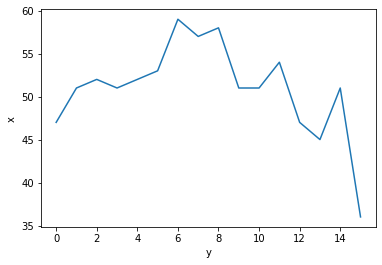

In [75]:
plo_ones_feature(labelList,0,zero_one_feature)

(array([  0,  26,  30,  32,  39,  40,  49,  53,  70,  72,  92, 101, 105,
       118, 121, 144, 149, 179, 186, 198, 203, 207, 208, 210, 212, 244,
       245, 247, 254, 265, 269, 309, 326, 338, 351, 365, 377, 381, 419,
       426, 428, 441, 442, 452, 458, 461, 474, 481, 484, 512, 521, 522,
       527, 533, 535, 541, 554, 555, 565, 568, 574, 585, 593, 597, 599,
       629, 632, 641, 643, 647, 653, 662, 674, 688, 689, 693, 699, 700,
       702, 713, 715, 728, 738, 742, 745, 754, 755, 775, 794, 807, 812,
       825], dtype=int64),)


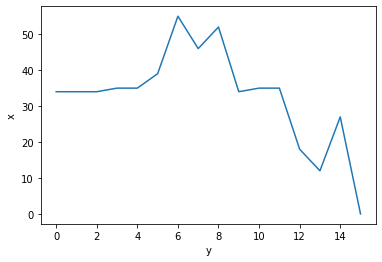

In [76]:
plo_ones_feature(labelList,1,zero_one_feature)

(array([  1,   5,   7,   8,  12,  15,  16,  18,  22,  23,  25,  28,  29,
        36,  43,  44,  47,  54,  56,  65,  76,  83,  85,  91,  96, 107,
       110, 113, 114, 122, 126, 131, 136, 143, 145, 147, 151, 152, 153,
       154, 156, 163, 177, 184, 185, 187, 189, 193, 202, 211, 216, 236,
       243, 253, 257, 263, 264, 271, 274, 275, 276, 292, 293, 295, 299,
       307, 312, 325, 331, 342, 347, 348, 349, 367, 371, 372, 375, 378,
       379, 383, 395, 396, 405, 410, 411, 417, 422, 431, 436, 450, 453,
       460, 464, 467, 472, 479, 496, 497, 502, 503, 507, 509, 513, 524,
       529, 530, 537, 542, 547, 552, 556, 562, 596, 600, 609, 610, 613,
       617, 624, 628, 633, 635, 652, 656, 659, 683, 697, 712, 719, 735,
       741, 744, 751, 752, 761, 763, 772, 782, 788, 789, 792, 803, 808,
       810, 814, 815, 822, 833, 834, 843], dtype=int64),)


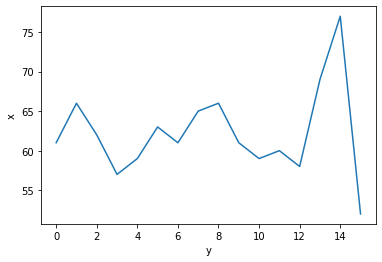

In [77]:
plo_ones_feature(labelList,2,zero_one_feature)

(array([ 33,  37,  52, 100, 112, 133, 150, 200, 227, 228, 242, 249, 268,
       285, 290, 291, 305, 311, 344, 353, 361, 368, 374, 403, 423, 430,
       451, 457, 480, 518, 525, 549, 558, 564, 575, 589, 594, 611, 620,
       649, 704, 711, 722, 727, 737, 746, 780, 832], dtype=int64),)


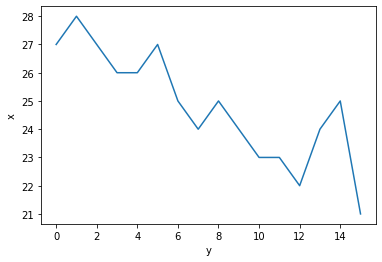

In [78]:
plo_ones_feature(labelList,3,zero_one_feature)

(array([  2,   3,  27,  31,  45,  51,  62,  67,  87,  97,  99, 138, 142,
       164, 165, 170, 172, 173, 191, 213, 214, 226, 238, 267, 278, 286,
       303, 306, 317, 319, 323, 334, 362, 376, 399, 416, 420, 427, 429,
       454, 459, 465, 466, 469, 501, 504, 528, 538, 546, 551, 563, 578,
       580, 591, 592, 601, 631, 638, 644, 658, 678, 682, 685, 690, 707,
       725, 729, 750, 758, 784, 785, 797, 799, 802, 811, 820, 823, 829,
       837, 844], dtype=int64),)


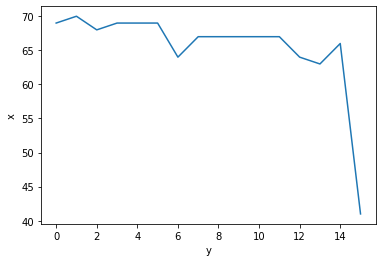

In [79]:
plo_ones_feature(labelList,4,zero_one_feature)

(array([  9,  24,  42,  58,  59,  68,  74,  77,  82,  88,  98, 111, 148,
       155, 168, 192, 209, 218, 221, 234, 235, 237, 248, 258, 259, 266,
       270, 283, 308, 318, 324, 328, 332, 340, 345, 358, 363, 380, 401,
       402, 412, 440, 456, 486, 488, 491, 492, 498, 500, 505, 510, 526,
       540, 569, 572, 579, 582, 587, 603, 606, 612, 627, 639, 651, 657,
       661, 666, 669, 684, 714, 730, 748, 773, 776, 777, 783, 786, 800,
       819, 821, 830, 839, 842], dtype=int64),)


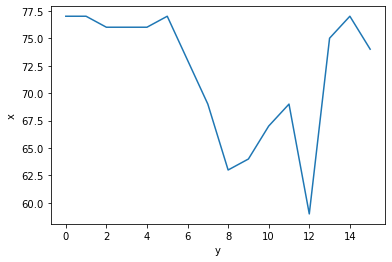

In [83]:
plo_ones_feature(labelList,7,zero_one_feature)

In [64]:
zero_one_feature = np.load("../model/zero_one_feature.npy")


In [42]:
feature_np=zero_one_feature[0:200]
# feature_np/=feature_np.sum(1, keepdims=True)
kmeans = KMeans(n_clusters=12,init='k-means++').fit(feature_np)
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

print('purity : ',purity_score(labelList[0:200],kmeans.labels_ ))
# print('ARI : ',adjusted_rand_score(labelList,kmeans.labels_))
# print('NMI : ',normalized_mutual_info_score(labelList,kmeans.labels_ ))

purity :  0.385


In [43]:
import scipy.stats as stats
from tqdm import tqdm

# 利用 超几何分布的 生存函数计算 相似度

num_pairs = int(zero_one_feature.shape[0]*(zero_one_feature.shape[0]-1)/2)


ab_vec = np.zeros((zero_one_feature.shape[0],  ))  #记录特征为1 的个数
activate_dict = {}# 储存为 特征矩阵 为1 的索引
 
for i in range(zero_one_feature.shape[0]):
    ab_vec[i] = np.sum(zero_one_feature[i])
    activate_dict[i] = np.where(zero_one_feature[i] == 1)
 

e = np.log10(num_pairs)


abc_dict = {}
def sf(a, b, c):
    key = (a, b, c)
    if not key in abc_dict:
        val = -np.log10(stats.hypergeom.sf(c - 1, zero_one_feature.shape[1], a, b)) - e
 
#         val = stats.hypergeom.pmf(c , zero_one_feature.shape[1], a, b)
 
        abc_dict[key] = val
        abc_dict[(b, a, c)] = val
    else:
        val = abc_dict[key]
    return val

np_adj=np.zeros(shape=[zero_one_feature.shape[0],zero_one_feature.shape[0]])

with tqdm(total=num_pairs) as pbar:
    for i in range(zero_one_feature.shape[0]):
        for j in range(i+1, zero_one_feature.shape[0]):
            pbar.update(1)
            a = ab_vec[i]#为1 的个数
            b = ab_vec[j]#为1 的个数
            c = np.intersect1d(activate_dict[i], activate_dict[j]).shape[0] # 都为1 的索引相同的个数

            similar= stats.hypergeom.pmf(c , zero_one_feature.shape[1], a, b)
#             similar= sf(a,b,c)
#             if similar>0:
            np_adj[i][j]=similar

 
    

100%|████████████████████████████████████████████████████████████████████████| 360825/360825 [00:55<00:00, 6558.44it/s]


In [44]:
for i in range(1,zero_one_feature.shape[0]):
    for j in range(0,i):

        np_adj[i][j]=np_adj[j][i]

In [46]:
            
# np_adj/=np_adj.sum(1, keepdims=True)  
        

np_adj[0]

array([0.        , 0.41785714, 0.51071429, 0.51071429, 0.41785714,
       0.41785714, 0.51071429, 0.51071429, 0.51071429, 0.51071429,
       0.41785714, 0.51071429, 0.51071429, 0.51071429, 0.51071429,
       0.51071429, 0.51071429, 0.41785714, 0.51071429, 0.51071429,
       0.41785714, 0.51071429, 0.51071429, 0.51071429, 0.51071429,
       0.51071429, 0.51071429, 0.51071429, 0.51071429, 0.41785714,
       0.51071429, 0.51071429, 0.51071429, 0.51071429, 0.41785714,
       0.41785714, 0.51071429, 0.51071429, 0.41785714, 0.51071429,
       0.51071429, 0.51071429, 0.51071429, 0.41785714, 0.51071429,
       0.51071429, 0.41785714, 0.51071429, 0.51071429, 0.06964286,
       0.51071429, 0.51071429, 0.51071429, 0.51071429, 0.51071429,
       0.41785714, 0.51071429, 0.51071429, 0.51071429, 0.51071429,
       0.51071429, 0.06964286, 0.51071429, 0.51071429, 0.41785714,
       0.51071429, 0.51071429, 0.51071429, 0.51071429, 0.51071429,
       0.51071429, 0.41785714, 0.51071429, 0.51071429, 0.41785

In [ ]:
import markov_clustering as mc

matrix = sp.csr_matrix(np.matrix(np_adj))

result = mc.run_mcl(matrix)
clusters = mc.get_clusters(result) 
Q = mc.modularity(matrix=result, clusters=clusters)
# print("modularity:", Q)

In [ ]:
len(clusters)

In [ ]:
from scipy.stats import hypergeom
import matplotlib.pyplot as plt 

[M, n, N] = [20, 7, 12]
rv = hypergeom(M, n, N)
x = np.arange(0, n+1)
pmf_dogs = rv.pmf(x)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, pmf_dogs, 'bo')
ax.vlines(x, 0, pmf_dogs, lw=2)
ax.set_xlabel('# of dogs in our group of chosen animals')
ax.set_ylabel('hypergeom PMF')
plt.show()

In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
class Contig_data(data.Dataset):
    def __init__(self, file, type='train'):
        self.type = type
        self.file = file
        # The last column is label, the other columns are the features
        df = pd.read_csv(self.file, header = None)
        self.labels = df.values[:, -1]
        # self.seqs = df.values[:, :-1].astype(np.float32)
        self.seqs = df.values[:, : -1].astype(np.float32)

    def __len__(self):
        return self.seqs.shape[0]

    def __getitem__(self, index):
        return self.seqs[index], self.labels[index]
    
test_data = Contig_data(file='../data/xubo_kmer/kmer.csv')
test_loader = DataLoader(test_data )
for batch_idx, (data, _) in enumerate(test_loader):
    print(data.shape)

In [ ]:
thresh = np.percentile([1,1,1,1,2], 90)

In [ ]:
thresh